In [1]:
# get images
!wget "https://raw.githubusercontent.com/jzhe727/colorizer/main/Humans/1%20(103).png" -P Humans
!wget "https://raw.githubusercontent.com/jzhe727/colorizer/main/Humans/1%20(104).png" -P Humans
!wget "https://raw.githubusercontent.com/jzhe727/colorizer/main/Humans/1%20(105).png" -P Humans
!wget "https://raw.githubusercontent.com/jzhe727/colorizer/main/Humans/1%20(106).png" -P Humans
!wget "https://raw.githubusercontent.com/jzhe727/colorizer/main/Humans/1%20(107).png" -P Humans

#get imports
%pip install import-ipynb
!wget https://raw.githubusercontent.com/jzhe727/colorizer/main/CUnet.ipynb
!wget https://raw.githubusercontent.com/jzhe727/colorizer/main/saved_model/CUNet_200_904.4260787963867.pth -P model



--2024-01-08 05:48:09--  https://raw.githubusercontent.com/jzhe727/colorizer/main/Humans/1%20(103).png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 596185 (582K) [image/png]
Saving to: ‘Humans/1 (103).png’

1 (103).png         100%[===================>] 582.21K  --.-KB/s    in 0.03s   

2024-01-08 05:48:09 (19.3 MB/s) - ‘Humans/1 (103).png’ saved [596185/596185]

--2024-01-08 05:48:10--  https://raw.githubusercontent.com/jzhe727/colorizer/main/Humans/1%20(104).png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1657772 (1.6M) [

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import glob
import random
import cv2
import imutils
from skimage import color
from skimage.util.dtype import convert
import import_ipynb #pip install import-ipynb
# from data import ImageNet
from CUnet import CUNet

from tqdm import tqdm

importing Jupyter notebook from CUnet.ipynb
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])


## Define models and data loaders and hyper-params

In [3]:
cu_model = CUNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cu_model = cu_model.to(device)

In [4]:
# Another dataset class incase mflickr is not enough data, based on a subset of Imagenet
class ImageNet(Dataset):
    '''
    Constructor
    Inputs:
        root -> root dir of images,
        ext -> optional extension of images, default jpg
        size -> optional, crops data size for faster testing
    '''
    def __init__(self, root, ext='.JPEG', size=None, transform=None):
        self.paths = glob.glob(f'{root}/*{ext}', recursive=True)
        self.size = size
        self.root = root
        self.transform = transform
        self.height = 256
        self.width = 256

        if size: #speed up testing
            self.paths = self.paths[:size]

    '''
    get the (l,ab) pair for image i
    '''
    def __getitem__(self, i):
        s = self.paths[i]
        img = (Image.open(s)).convert('RGB')
        if self.transform:
            img = img.resize((self.height, self.width))
            # img = convert(img, np.float32) # [256,256,3]
            # img = transforms.ToTensor(img, torch.float32)
            img = color.rgb2lab(img)
            img = self.transform(img).float() # [3, 256, 256]

        l = (img[0,:,:])[None,:,:]
        ab = img[1:,:,:]
        return l, ab

    '''
    get the l,ab pair for image i, no transforms
    '''
    def get_original(self, i):
        s = self.paths[i]
        img = (Image.open(s)).convert('RGB')
        img = color.rgb2lab(img)
        img = self.transform(img) # [3, 256, 256]

        l = (img[0,:,:])[None,:,:]
        ab = img[1:,:,:]
        return l, ab

    '''
    return length of dataset
    '''
    def __len__(self):
        return(len(self.paths))

    '''
    Input:
        tens_orig_l -> [batch_size, 1, height, width]
        out_ab      -> [batch_size, 2, 256,    256]
    tens_orig_l is the original images L dimension that is obtained from pre processing
    out_ab is the 2-channel prediction outputted by the model
    '''
    def postprocess_batch(tens_orig_l, out_ab):
        out_shape = out_ab.shape[2:]
        orig_shape = tens_orig_l.shape[2:]

        # resize the model prediction to original image size using interpolate
        if(out_shape!=orig_shape):
            out_ab_orig = F.interpolate(out_ab, size=orig_shape, mode='bilinear')

        concat = torch.cat((tens_orig_l, out_ab_orig), dim=1) # [batch_size, 3, height, width]
        return concat

    '''
    This function takes in an image and resizes it to 256 by 256
    '''
    def resize_img(self, img):
        return (img.resize((self.height, self.width)))

    '''
    take a random index i, get the original image, and the predicted image
    print them side by side
    '''
    def check_output(self, i, model):
        model.eval()
        l_org, ab_org = self.get_original(i)
        img_original = self.rebuild_image(l_org, ab_org)

        l,ab = self[i]
        l = l[None,:,:,:] # add 4th dim to l so we can feed to model

        with torch.no_grad():
            l = l.to(device)
            pred_ab = model(l)
        pred_ab = torch.squeeze(pred_ab, dim=0)
        l = torch.squeeze(l, dim=0)

        pred_ab = pred_ab.to("cpu")
        l = l.to("cpu")

        img_pred = self.rebuild_image(l,pred_ab) # needs to be upsized with post_process function still
        return img_original, img_pred

    '''
    Selects random start point in the dataset and prints 7 images
    '''
    def print_samples(self):
        figure, axes = plt.subplots(1, 7, figsize=(18,10))
        axes = axes.flatten()
        max_idx = self.size if self.size!=None else len(self.paths)
        i = random.randint(0, max_idx)
        for axis in axes:
            l, ab = self[i]
            img = self.rebuild_image(l,ab)
            axis.imshow(img)
            axis.set_xlabel(i)
            i+=1
        plt.show()

    '''
    prints all three LAB channels of a given image index.
    also demonstrates how to rebuild original image from l,a,b channels
    '''
    def print_lab_channels(self,index):
        img_l, img_ab = self[index]

        img_lab = torch.concat((img_l,img_ab), dim=0).permute(1,2,0)
        l = torch.Tensor(img_l)
        a = torch.Tensor(img_ab[0,:,:])[None,:,:]
        b = torch.Tensor(img_ab[1,:,:])[None,:,:]

        figure, axes = plt.subplots(1, 5, figsize=(18,10))
        axes = axes.flatten()

        # Plot lab iamge and all 3 channels seperately
        axes[0].imshow(img_lab) # currently weird colors because img_lab contains negative values
        axes[0].set_xlabel("LAB image")
        axes[1].imshow(l.permute(1,2,0),cmap="gray")
        axes[1].set_xlabel("L Channel")
        axes[2].imshow(a.permute(1,2,0))
        axes[2].set_xlabel("A Channel")
        axes[3].imshow(b.permute(1,2,0))
        axes[3].set_xlabel("B Channel")

        orig = self.rebuild_image(img_l,img_ab)
        axes[4].imshow(orig)
        axes[4].set_xlabel("Rebuilt image")

        plt.tight_layout()
        plt.show()

    '''
    takes an index and prints the original plus the L channel image
    side by side
    '''
    def print_side_by_side(self,i):
        l,ab = self[i]

        img = self.rebuild_image(l,ab)
        l = l.permute(1,2,0) # original size l

        figure, axes = plt.subplots(1, 2, figsize=(18,10))
        axes = axes.flatten()
        axes[0].imshow(img)
        axes[1].imshow(l, cmap="gray")
        plt.tight_layout()
        plt.show()

    '''
    rebuilds original rgb image from l,ab inputs
    '''
    def rebuild_image(self, l, ab):
        return color.lab2rgb(torch.cat((l,ab), dim=0).permute(1,2,0))

    '''
    Calculates average width and height of all images in dataset
    '''
    def calc_average_dimension(self):
        totalw = 0
        totalh = 0
        for i in range(len(self.paths)):
            image = Image.open(self.paths[i])
            w, h = image.size
            totalw += w
            totalh += h
        avgw = totalw//len(self.paths)
        avgh = totalh//len(self.paths)
        return avgw, avgh

In [5]:
trans = transforms.Compose([transforms.ToTensor()])
ImageNet_eval_dataset = ImageNet(root="./Humans", ext='.png',transform=trans)

In [6]:
def print_comparisons(start,model):
    for i in range(start,start+5):
        org1, pred1 = ImageNet_eval_dataset.check_output(i,model)
        org1_resize = Image.fromarray((org1 * 255).astype(np.uint8)).resize((256,256)) # get resize image

        figure, axes = plt.subplots(1, 2, figsize=(18,10))
        axes = axes.flatten()
        axes[0].imshow(org1_resize) # show resized image instead of original size image
        axes[1].imshow(pred1)

In [7]:
def name_to_epoch(name):
    _, epoch, _ = name.split("_") #name, epoch, avg_l.pth
    return(int(epoch))

In [8]:
def get_latest_weights(model):
    paths = glob.glob(f'model/{type(model).__name__}_*.pth')
    #only find models that have the same type as the model being trained

    paths.sort(key = name_to_epoch) #most recent epoch
    start = -1
    if len(paths) > 0:
        target = paths[-1]
        start = name_to_epoch(target)
        model.load_state_dict(torch.load(target))
    return start

### Eval Models

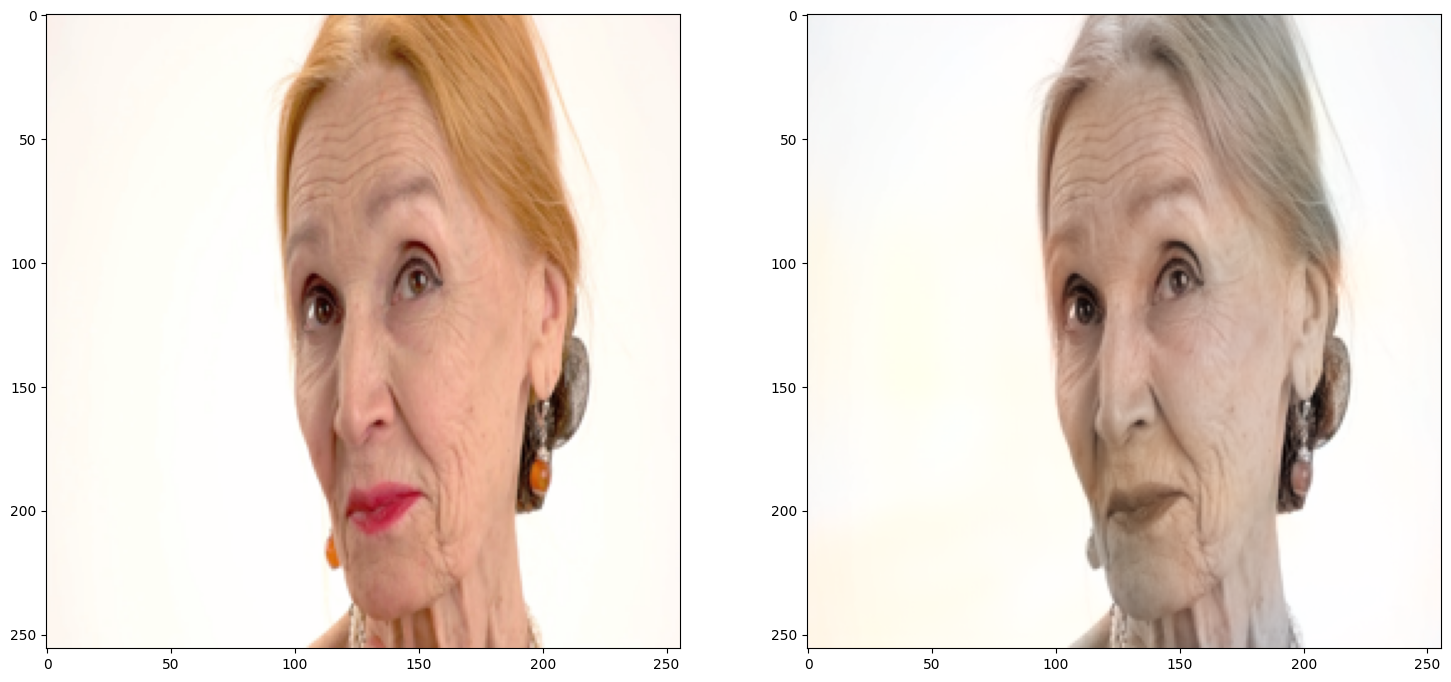

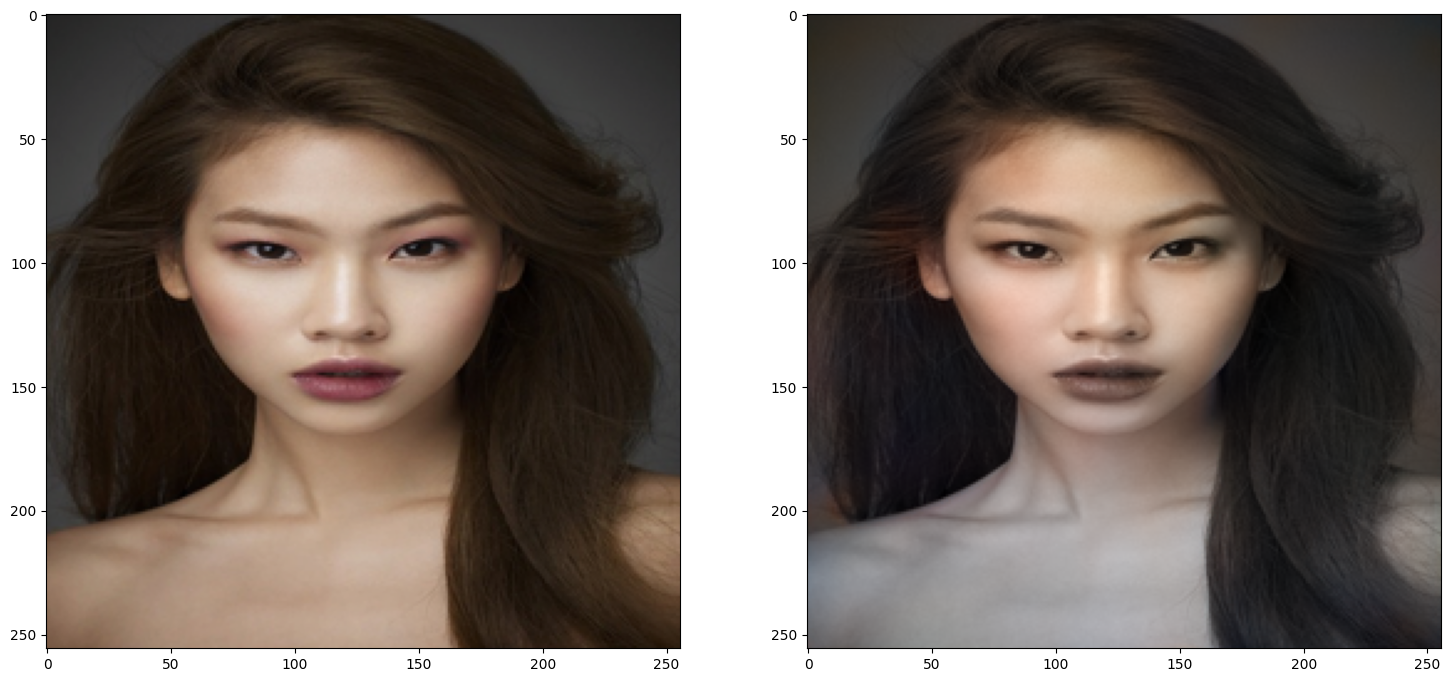

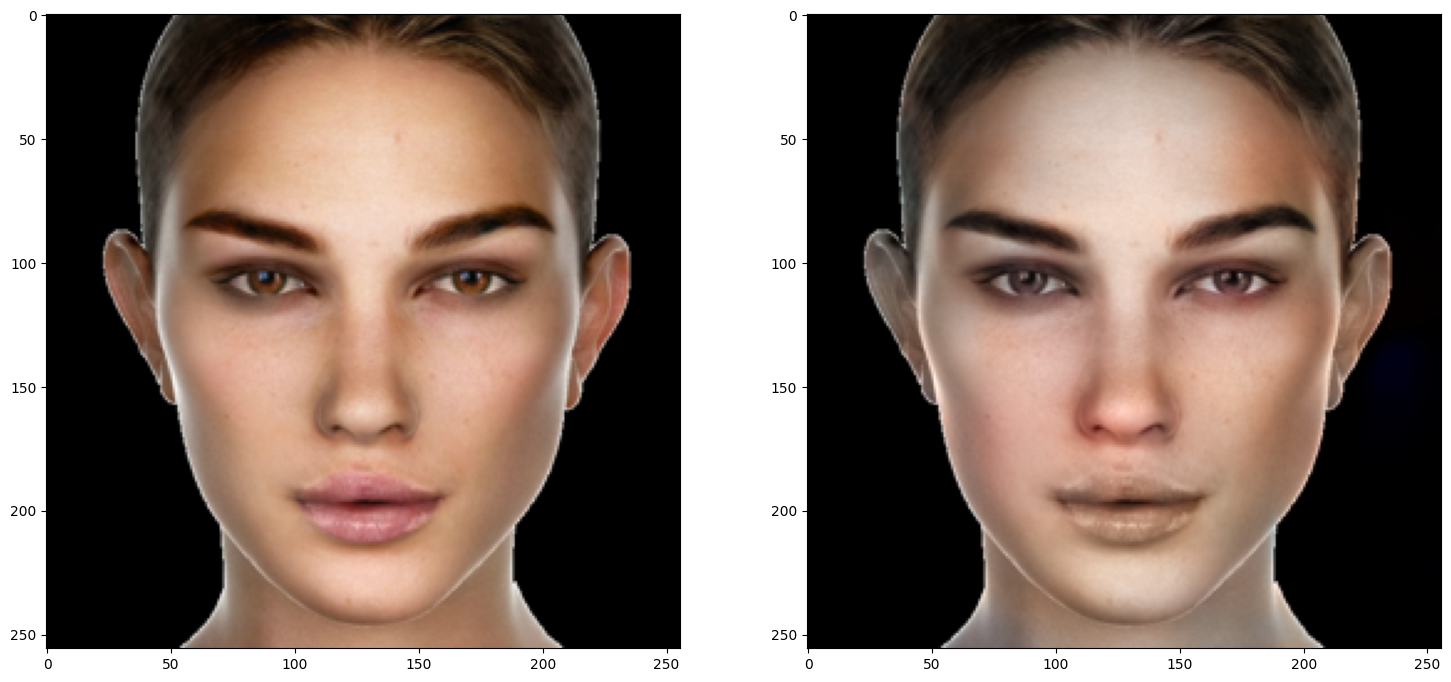

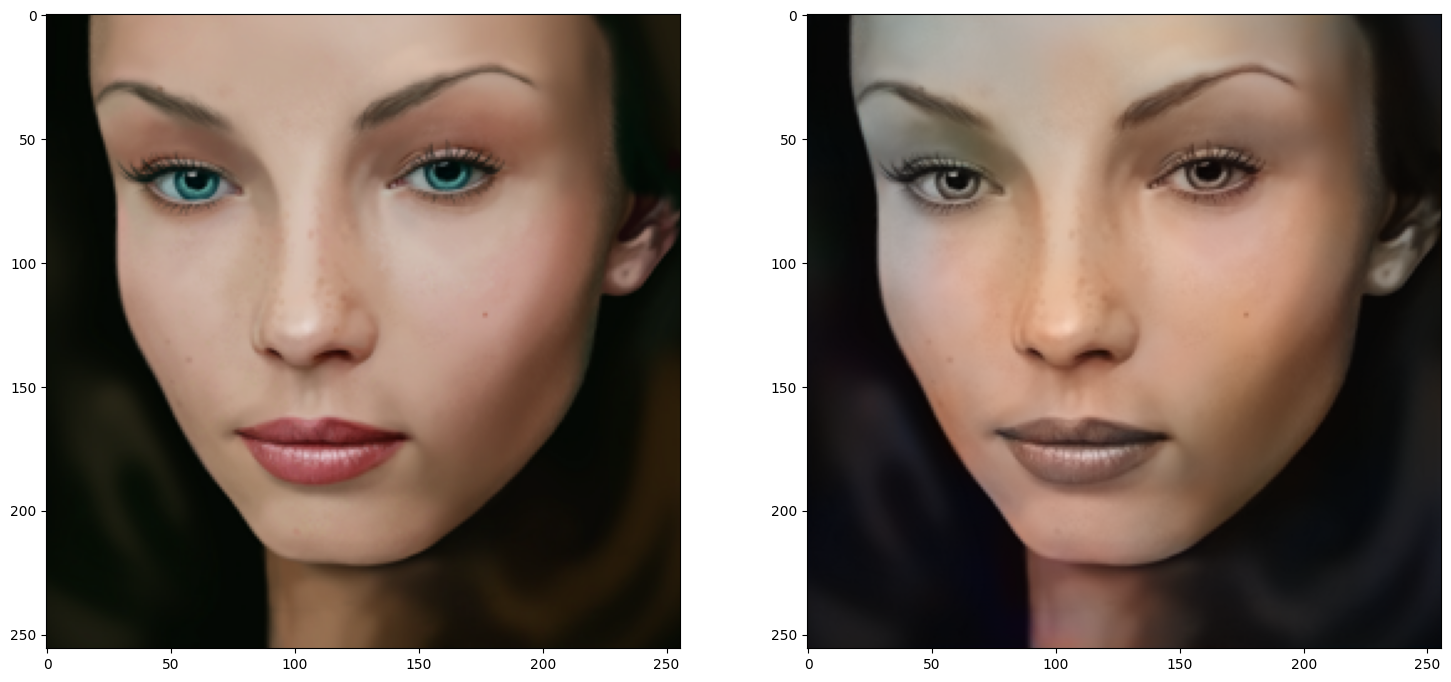

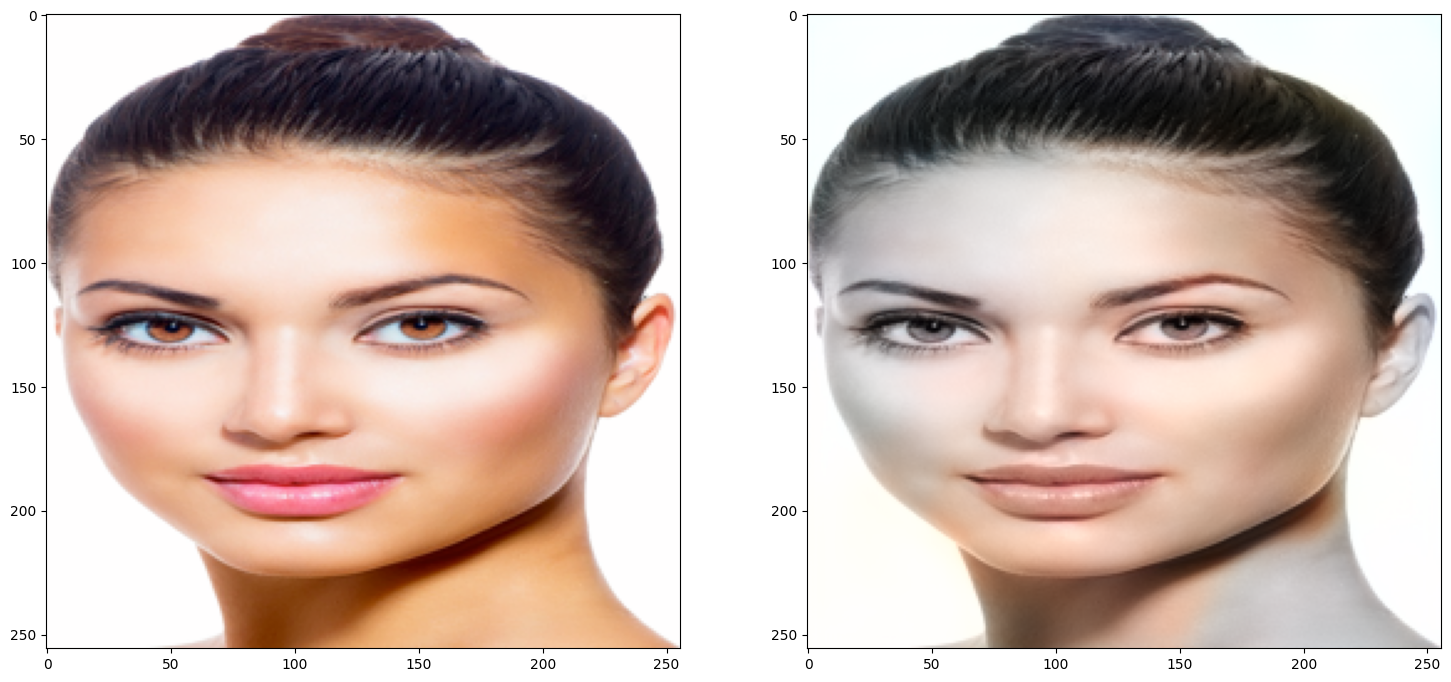

In [9]:
temp = get_latest_weights(cu_model)
print_comparisons(0,cu_model)